# PyTorch CNN Model

## 0. Importing PyTorch Modules and setting up device

In [3]:
import torch
import torchvision
import helper_funcs as hlp
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__, device


('2.3.0+cu121', 'cuda')

## 1. Load Dataset

In [5]:
# Determine Image Size
IMAGE_X = 128
IMAGE_Y = 128
IMAGE_SIZE = (IMAGE_X, IMAGE_Y)

# Set Train and Test Directories
root_dir  = 'drive/MyDrive/PyTorch/dataset_egp'
train_dir = root_dir + "/train"
test_dir  = root_dir + '/test'

# Get transform from model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

# Get Train and Test data
train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=auto_transforms)
class_names = train_data.classes

auto_transforms, train_data, test_data, class_names

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 Dataset ImageFolder
     Number of datapoints: 2560
     Root location: drive/MyDrive/PyTorch/dataset_egp/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 600
     Root location: drive/MyDrive/PyTorch/dataset_egp/test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 ['egp_10',
  'egp_100',
  'egp_10_new',
 

## 2. Visualize Data

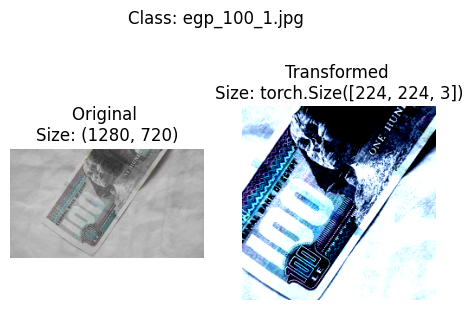

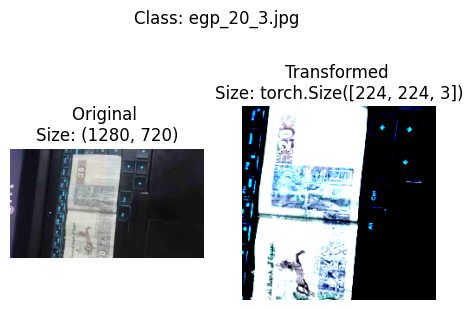

In [6]:
# Plot Images after transforming
hlp.plot_transformed_images(image_paths=root_dir, transform=auto_transforms, n=2)

## 3. Group Data to batches

In [7]:
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader  = DataLoader(dataset=test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7af7f05ca470>,
 <torch.utils.data.dataloader.DataLoader at 0x7af7f05cbd90>)

## 4. Load Pre-trained Model

In [8]:
TRAINED_MODEL_PATH = 'trained_model.pth'

trained_model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in trained_model.features.parameters():
  param.requires_grad = False

trained_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

try:
    trained_model.load_state_dict(torch.load(f=TRAINED_MODEL_PATH))
except FileNotFoundError:
    pass

trained_model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Verify Model using torchinfo.summary
summary(model=trained_model,input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 8]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 5. Train Model

In [10]:
# Number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=trained_model.parameters(), lr=0.001)

trained_model_results = hlp.train_model(model=trained_model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device)

# Save Model
torch.save(obj=trained_model.state_dict(),f=TRAINED_MODEL_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4800 | train_acc: 0.6062 | test_loss: 0.9276 | test_acc: 0.8520
Epoch: 2 | train_loss: 0.8266 | train_acc: 0.8473 | test_loss: 0.6188 | test_acc: 0.9084
Epoch: 3 | train_loss: 0.5939 | train_acc: 0.8855 | test_loss: 0.4772 | test_acc: 0.9205
Epoch: 4 | train_loss: 0.4961 | train_acc: 0.9004 | test_loss: 0.3968 | test_acc: 0.9348
Epoch: 5 | train_loss: 0.4153 | train_acc: 0.9160 | test_loss: 0.3419 | test_acc: 0.9446
Epoch: 6 | train_loss: 0.3638 | train_acc: 0.9262 | test_loss: 0.3082 | test_acc: 0.9408
Epoch: 7 | train_loss: 0.3246 | train_acc: 0.9309 | test_loss: 0.2750 | test_acc: 0.9507
Epoch: 8 | train_loss: 0.3017 | train_acc: 0.9297 | test_loss: 0.2617 | test_acc: 0.9457
Epoch: 9 | train_loss: 0.2812 | train_acc: 0.9395 | test_loss: 0.2383 | test_acc: 0.9523
Epoch: 10 | train_loss: 0.2579 | train_acc: 0.9441 | test_loss: 0.2237 | test_acc: 0.9512


## 6. Evaluate Model

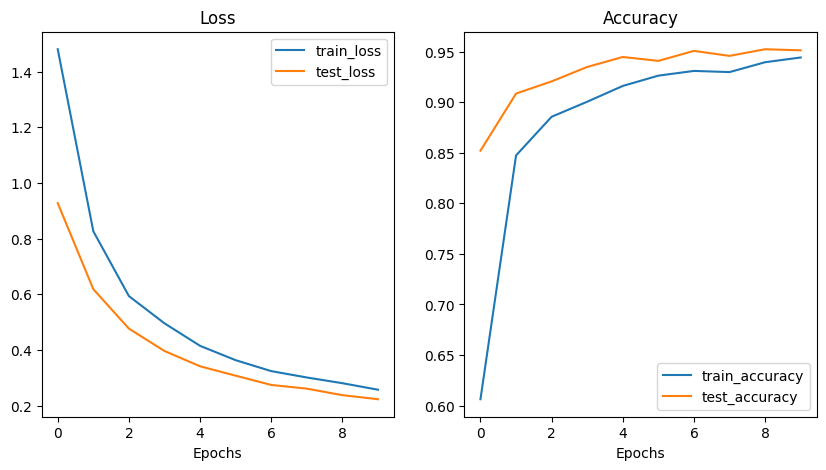

In [11]:
hlp.plot_loss_curves(trained_model_results)

## 7. Predict using custom data

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_200_3.jpg


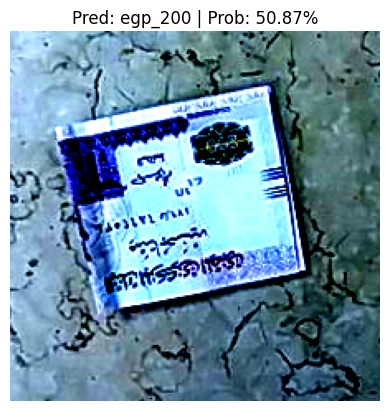

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_10_3.jpg


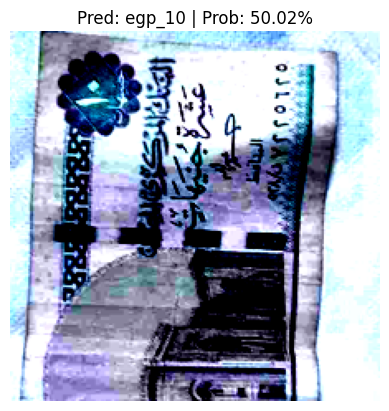

In [13]:
test_dir = root_dir + '/validate'

hlp.pred_and_plot_images(model=trained_model, image_dir=test_dir, class_names=class_names,
                         transform=auto_transforms, device=device,num_images=2)